In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Parameters of the system and basic function definitions

In [8]:
# Parameters
args = {
    "beta_HIV": 0.6341 / 360.0,
    "beta_STI": 0.0016 * 5,
    "mu": 1.0 / 45.0 / 360.0,
    "gamma_STI": 1.0 / 1.32 / 360.0,
    "gammaT_STI": 1.0 / 7.0,  # Try also with 1/14
    "lambda_P": 2 / 360,
    "asymptomatic": 0.85,
    "lambda_0": 1 / 14,
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.0,
    "tau": 0.2,
    "c": 50.0,
    "minexp": 0,
    "H": 0,
    "P_HIV": 0.0,
    "maxexp": 1,
}


# Mitigation function
def m(H, min_exp=args["minexp"], max_exp=args["maxexp"], tau_exp=args["tau"]):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))


# Alpha
def alpha(P, H, beta_STI=args["beta_STI"]):
    return beta_STI * (1 - m(H) * (1 - P))

# Heatmap for $\lambda_P$

C:\Users\anton\AppData\Local\Temp\ipykernel_9484\653772608.py:18: RuntimeWarning: invalid value encountered in log
  return np.log(term1-term2)


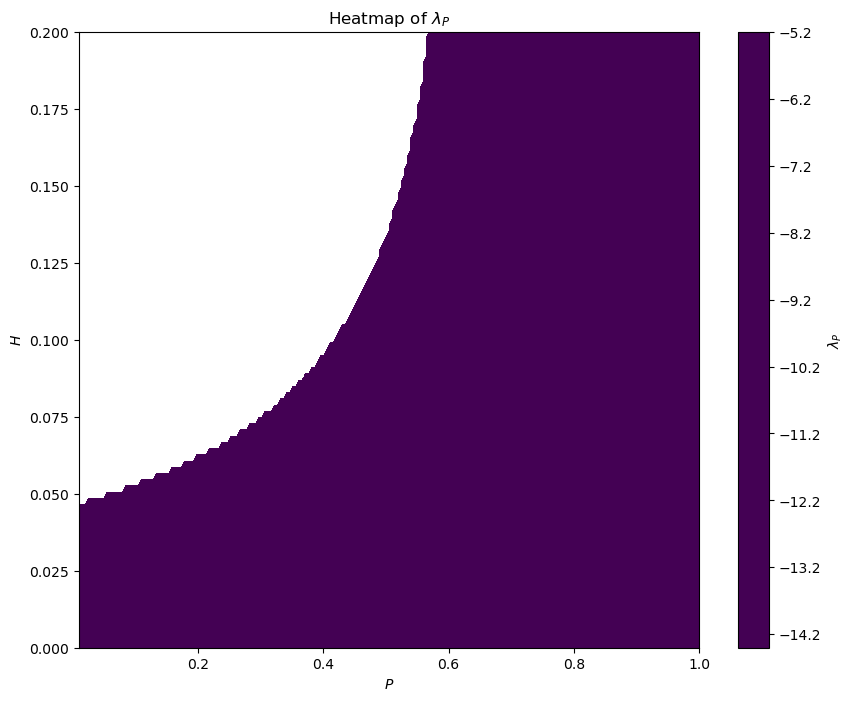

In [145]:
beta_STI_0 = 0.0016 * 5
psi = 0.85
mu = 1.0 / 45.0 / 360.0
gamma = 1.0 / 1.32 / 360.0
C = 50
beta_HIV = 0.6341 / 360.0
min_exp = 0.0
max_exp = 1.0
tau_exp = 0.2
lambda_0 = 1 / 14


# Explicit expression for lambda_P
def lambda_P(P, H):
    term1 = (
        psi
        * (mu + lambda_0)
        / ((mu + lambda_0) / (beta_STI_0 * (1 - m(H) * (1 - P))) - (1 - psi))
    )
    term2 = gamma + C * (1 - m(H)) * beta_HIV * H * (1 - P) + mu
    return np.log(term1 - term2)


# Define the ranges for H and P values
H_values = np.linspace(0, 0.2, 100)
P_values = np.linspace(0.01, 1, 201)  # Avoid P = 0 to prevent division by zero

# Initialize a 2D array to hold lambda_P values
lambda_P_grid = np.zeros((len(H_values), len(P_values)))

# Calculate lambda_P for each combination of H and P
for i, H in enumerate(H_values):
    for j, P in enumerate(P_values):
        lambda_P_grid[i, j] = lambda_P(P, H)

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(
    P_values, H_values, lambda_P_grid, levels=50, cmap="viridis", vmin=-1, vmax=1
)
plt.colorbar(label="$\lambda_P$")
plt.xlabel("$P$")
plt.ylabel("$H$")
plt.title("Heatmap of $\lambda_P$")
plt.show()

# Asym. Infections (H,P) heatmap for different $\lambda_P$

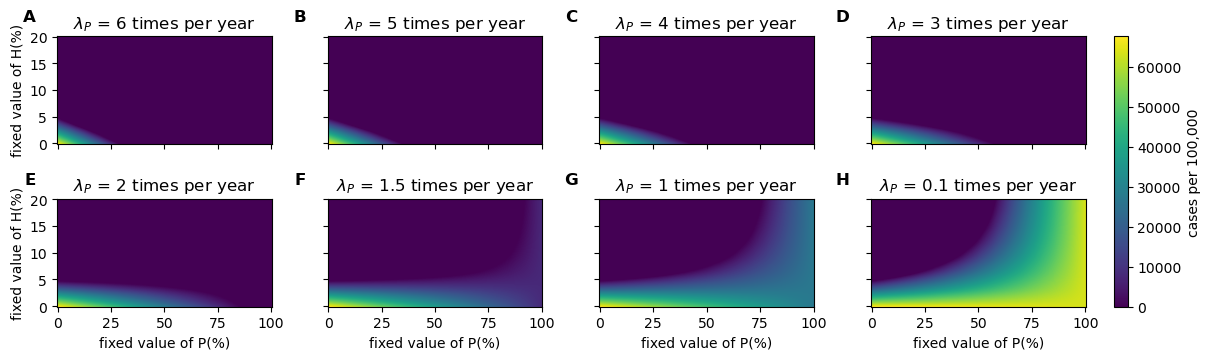

In [177]:
# Define the equation for I^{a,*}_{STI}
def I_star_STI(
    H,
    P,
    lam_P,
    lambda_0=args["lambda_0"],
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    P_star = P
    H_star = H
    m_star = m(H_star)
    alpha_val = alpha(P_star, H_star)

    term1 = (mu + tgamma) * (
        (mu + lambda_0)
        / (
            (psi * alpha_val * (mu + lambda_0))
            / (
                gamma
                + lam_P * P_star
                + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                + mu
            )
            + (1 - psi) * alpha_val
        )
        - 1
    )
    term2 = (
        -(
            gamma
            + lam_P * P_star
            + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
            + mu
        )
        / psi
    )
    term3 = gamma - tgamma * (
        1
        + (
            (
                gamma
                + lam_P * P_star
                + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                + mu
            )
            / (lambda_0 + mu)
        )
        * ((1 - psi) / psi)
    )

    numerator = term1
    denominator = term2 + term3

    return numerator / denominator


# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]

# Calculate log(I_star_STI) values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            if I_star_STI(H, P, lambda_P) > 0:
                I_values[i, j] = I_star_STI(H, P, lambda_P)
    results[lambda_P] = I_values

# Determine the global vmin and vmax for log(I_star_STI)
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Plotting
num_lambda_P = len(lambda_P_values)
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")


plt.show()

# Heatmap (H,P) for bifurcation parameter $R_o$

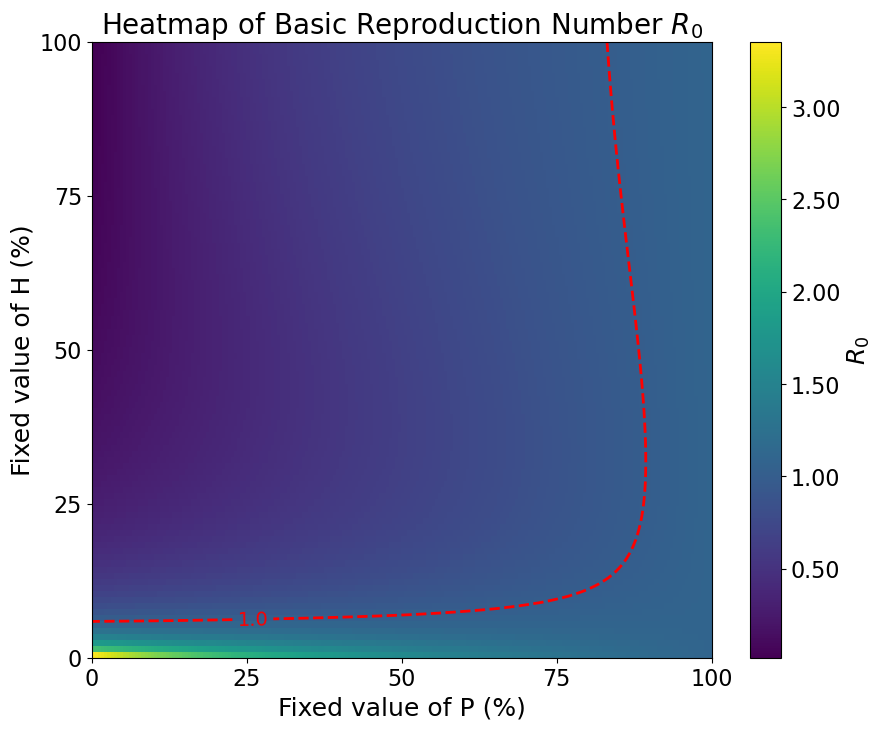

In [146]:
# Define the reproduction number
def Ro(
    H,
    P,
    lambda_0=args["lambda_0"],
    lam_P=args["lambda_P"],
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    alpha_val = alpha(P, H)
    term1 = (
        psi
        * alpha_val
        * (lambda_0 + mu)
        / (gamma + lam_P * P + C * (1 - m(H)) * beta_HIV * H * (1 - P) + mu)
    )
    term2 = (1 - psi) * alpha_val
    return (term1 + term2) / (lambda_0 + mu)


# Define the ranges for H and P values
Hs = np.linspace(0, 1.0, 101)
Ps = np.linspace(0, 1.0, 201)

# Calculate Ro values for each combination of H and P
Ro_values = np.zeros((len(Hs), len(Ps)))
for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        Ro_values[i, j] = Ro(H, P, args["lambda_P"])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(
    Ro_values,
    origin="lower",
    aspect="auto",
    extent=[Ps.min(), Ps.max(), Hs.min(), Hs.max()],
    cmap="viridis",
)

# Titles and labels
ax.set_title("Heatmap of Basic Reproduction Number $R_0$", fontsize=20)
ax.set_xlabel("Fixed value of P (%)", fontsize=18)
ax.set_ylabel("Fixed value of H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=16
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16
)


# Define a formatter function for the color bar
def formatter(x, pos):
    return f"{x:.2f}"


# Create a color bar with a larger font size
cbar = fig.colorbar(cax, ax=ax, format=FuncFormatter(formatter))
cbar.ax.set_ylabel("$R_0$", fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Add a contour line for R_0 = 1
contour = ax.contour(
    Ps, Hs, Ro_values, levels=[1], colors="red", linewidths=2, linestyles="--"
)

# Add a label to the contour line
ax.clabel(contour, inline=True, fontsize=14, fmt="%.1f", colors="red")

plt.show()

# $R_o$ for an specific set of (H,P)

The value of R_0 for (H, P) = (0.5, 0.5) is: 0.55


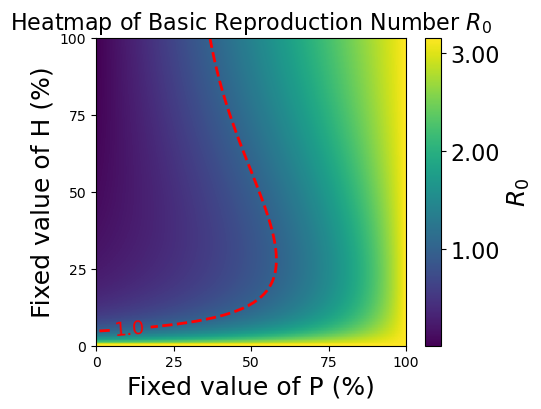

In [9]:
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

# Define specific (H, P) values
H_value = 0.5
P_value = 0.5

# Calculate R_0 for the specific (H, P) values
R0_value = Ro(H_value, P_value, args["lambda_P"])

# Print the value of R_0
print(f"The value of R_0 for (H, P) = ({H_value}, {P_value}) is: {R0_value:.2f}")

# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(
    Ro_values,
    origin="lower",
    aspect="auto",
    extent=[Ps.min(), Ps.max(), Hs.min(), Hs.max()],
    cmap="viridis",
)

# Titles and labels
ax.set_title("Heatmap of Basic Reproduction Number $R_0$", fontsize=16)
ax.set_xlabel("Fixed value of P (%)", fontsize=18)
ax.set_ylabel("Fixed value of H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=10
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=10
)


# Define a formatter function for the color bar
def formatter(x, pos):
    return f"{x:.2f}"


# Create a color bar with a larger font size
cbar = fig.colorbar(cax, ax=ax, format=FuncFormatter(formatter))
cbar.ax.set_ylabel("$R_0$", fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Add a contour line for R_0 = 1
contour = ax.contour(
    Ps, Hs, Ro_values, levels=[1], colors="red", linewidths=2, linestyles="--"
)

# Add a label to the contour line
ax.clabel(contour, inline=True, fontsize=14, fmt="%.1f", colors="red")

plt.show()

# Difference between basic reproduction number $R_o$ in terms of different $\lambda_P$

C:\Users\anton\AppData\Local\Temp\ipykernel_9484\3661308535.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


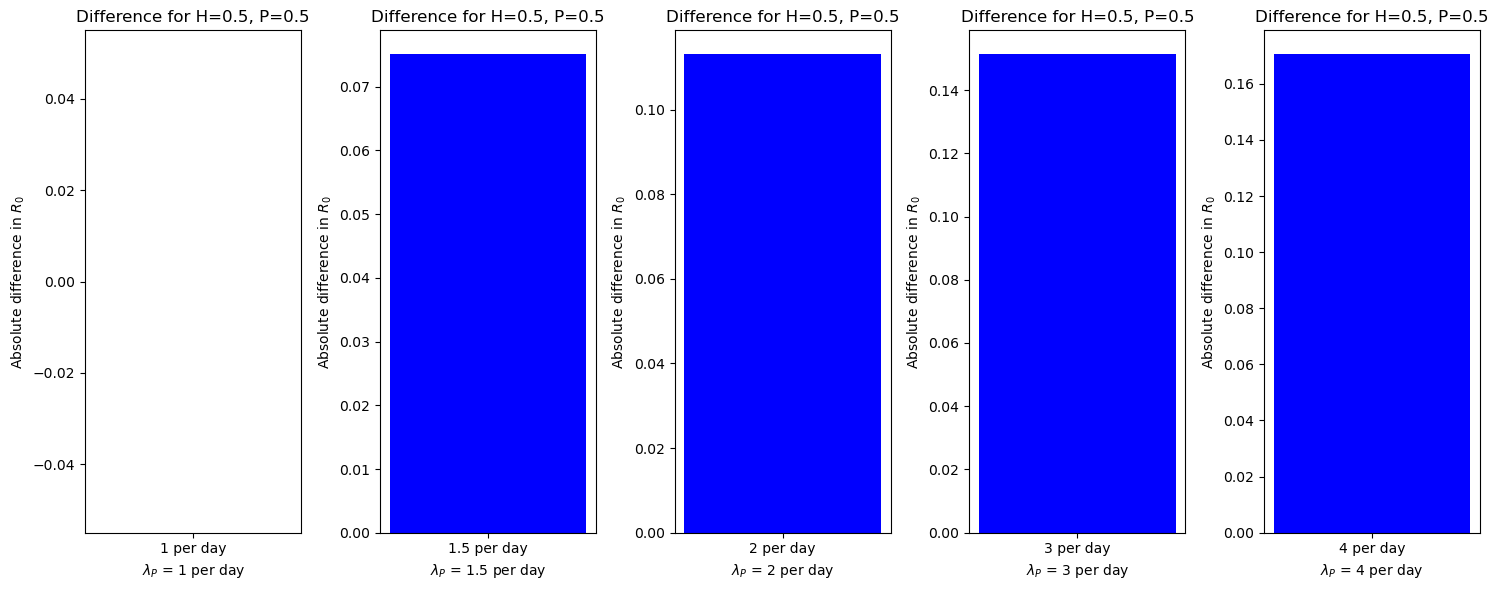

In [141]:
# Define the ranges for H and P values
Hs = np.linspace(0, 1.0, 201)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [1 / 360.0, 1.5 / 360.0, 2 / 360.0, 3 / 360.0, 4 / 360.0]

lambda_P_labels = ["1 per day", "1.5 per day", "2 per day", "3 per day", "4 per day"]

# Calculate Ro values for each combination of H and P for different lambda_P values
Ro_results = {}
for lambda_P in lambda_P_values:
    Ro_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            Ro_values[i, j] = Ro(H, P, lambda_P)
    Ro_results[lambda_P] = Ro_values

# Select a specific (H, P) to calculate differences
specific_H = 0.5
specific_P = 0.5
# Find the indices for specific H and P
H_index = np.argmin(np.abs(Hs - specific_H))
P_index = np.argmin(np.abs(Ps - specific_P))

# Calculate Ro for the specific (H, P) and compute differences
Ro_specific = {
    lambda_P: Ro_results[lambda_P][H_index, P_index] for lambda_P in lambda_P_values
}
Ro_diff = abs(
    np.array([Ro_specific[lambda_P] for lambda_P in lambda_P_values])
    - Ro_specific[lambda_P_values[0]]
)

# Plotting
fig, axes = plt.subplots(
    1, len(lambda_P_values), figsize=(15, 6), constrained_layout=True
)

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes[idx]
    diff = Ro_diff[idx]
    ax.bar(lambda_P_labels[idx], diff, color="b")
    ax.set_title(f"Difference for H={specific_H}, P={specific_P}")
    ax.set_xlabel(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_ylabel("Absolute difference in $R_0$")

plt.tight_layout()
plt.show()

# Sym. Infections (H,P) heatmap for different $\lambda_P$

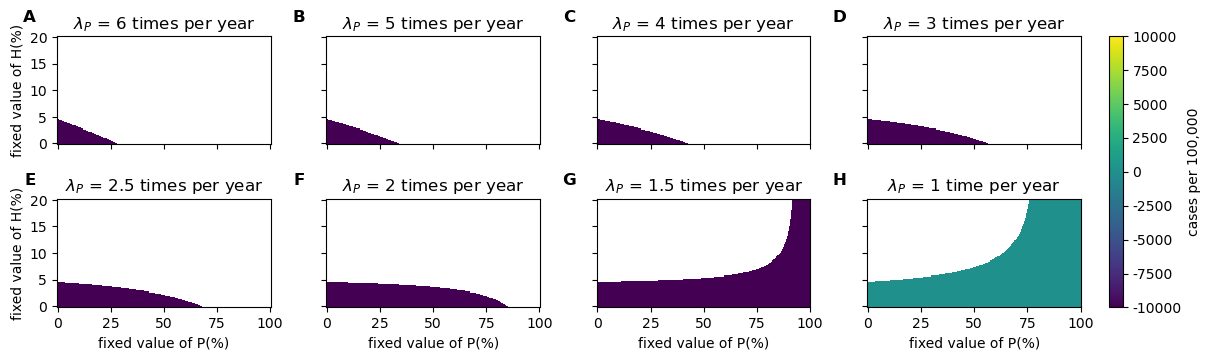

In [179]:
# Define the equation for I^{s}_{STI}
def I_star_symptomatic(
    H,
    P,
    lam_P,
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    I_star_asym = I_star_STI(H, P, lam_P, beta_HIV, mu, gamma, C, psi, tgamma)
    lambda_STI = lam_P * P + C * (1 - m(H)) * beta_HIV * H * (1 - P)
    I_star_sym = ((gamma + lambda_STI + mu) / mu) * ((1 - psi) / psi) * I_star_asym
    return I_star_sym


# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2.5 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 time per year",
]

# Calculate I_star_STI values for each combination of H, P, and lambda_P
results_asymptomatic = {}
results_symptomatic = {}
for lambda_P in lambda_P_values:
    I_values_asymptomatic = np.zeros((len(Hs), len(Ps)))
    I_values_symptomatic = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            I_values_symptomatic[i, j] = I_star_symptomatic(H, P, lambda_P)
    results_symptomatic[lambda_P] = I_values_symptomatic

# Determine the global vmin and vmax for symptomatic cases
all_infections_symptomatic = np.concatenate(
    [results_symptomatic[lambda_P].flatten() for lambda_P in lambda_P_values]
)
global_vmin_symptomatic = np.min(all_infections_symptomatic)
global_vmax_symptomatic = np.max(all_infections_symptomatic)

# Plotting
num_lambda_P = len(lambda_P_values)
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results_symptomatic[lambda_P]
    cax = ax.imshow(
        res_infections,
        origin="lower",
        vmin=global_vmin_symptomatic,
        vmax=global_vmax_symptomatic,
    )
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()

# Contour for $R_o=1$

1.7099944155591433


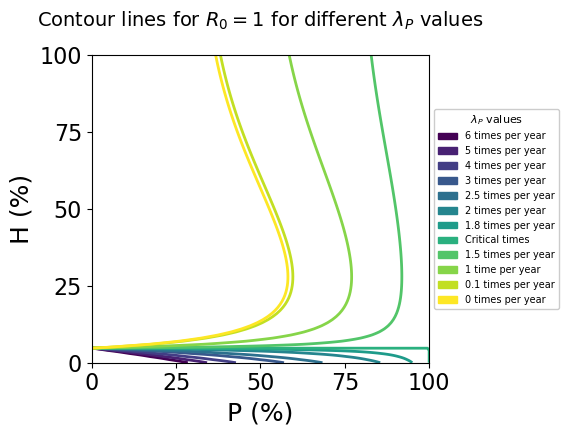

In [22]:
from matplotlib.patches import Patch


# Define the reproduction number function
def Ro(
    H,
    P,
    lambda_P,
    lambda_0=args["lambda_0"],
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    alpha_val = alpha(P, H)
    term1 = (
        psi
        * alpha_val
        * (lambda_0 + mu)
        / (gamma + lambda_P * P + C * (1 - m(H)) * beta_HIV * H * (1 - P) + mu)
    )
    term2 = (1 - psi) * alpha_val
    return (term1 + term2) / (lambda_0 + mu)


def bifurcationP(
    betaSTI=args["beta_STI"],
    lambda_0=args["lambda_0"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    psi=args["asymptomatic"],
):
    lambdap = (
        psi * (lambda_0 + mu) / ((lambda_0 + mu) / betaSTI - (1 - psi)) - mu - gamma
    )
    return lambdap


bifur = bifurcationP()
print(bifur * 360)
# Define the ranges for H and P values
Hs = np.linspace(0, 1.0, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2.5 / 360.0,
    2 / 360.0,
    1.8 / 360,
    bifur,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360,
    0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.8 times per year",
    "Critical times",
    "1.5 times per year",
    "1 time per year",
    "0.1 times per year",
    "0 times per year",
]

colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values)))

# Plotting the contour lines for R_0 = 1 for different lambda_P values
fig, ax = plt.subplots(figsize=(5, 4))

for lambda_P, color in zip(lambda_P_values, colors):
    # Calculate Ro values for each combination of H and P
    Ro_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            Ro_values[i, j] = Ro(H, P, lambda_P)

    # Add a contour line for R_0 = 1
    ax.contour(
        Ps, Hs, Ro_values, levels=[1], linewidths=2, linestyles="-", colors=[color]
    )

# Titles and labels
ax.set_title(
    "Contour lines for $R_0 = 1$ for different $\lambda_P$ values", fontsize=14, pad=20
)
ax.set_xlabel("P (%)", fontsize=18)
ax.set_ylabel("H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=16
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16
)

# Adding a custom legend outside the plot
legend_patches = [
    Patch(color=color, label=label) for color, label in zip(colors, lambda_P_labels)
]
legend = ax.legend(
    handles=legend_patches,
    title="$\lambda_P$ values",
    fontsize=7,
    title_fontsize=8,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(1)

# ax.set_xlim(0.7, 1.0)  # Adjust x-axis limits
# ax.set_ylim(0, 0.3)    # Adjust y-axis limits

# Adjusting the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.show()

# "Continuos" lambda_P

C:\Users\anton\AppData\Local\Temp\ipykernel_9948\4267696945.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(P_grid, H_grid, Ro_values, levels=[1], linewidths=2, linestyles='-', label=f'{lambda_P*360:.1f} times per year')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


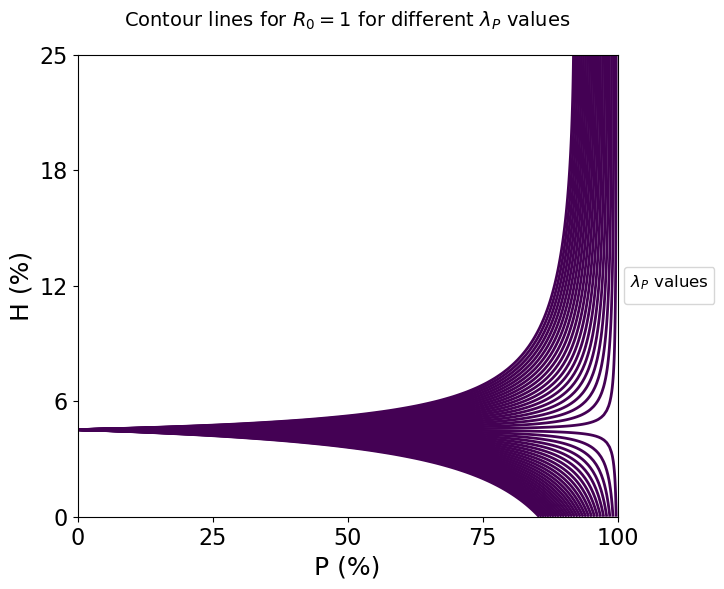

In [83]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.25, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the continuous range for lambda_P
lambda_P_min = 1.5 / 360.0
lambda_P_max = 2 / 360.0
lambda_P_values = np.linspace(
    lambda_P_min, lambda_P_max, 50
)  # Adjust the number of values for smoothness

# Plotting the contour lines for R_0 = 1 for different lambda_P values
fig, ax = plt.subplots(figsize=(8, 6))

# Generate a grid of H and P values
H_grid, P_grid = np.meshgrid(Hs, Ps)

# Calculate Ro values for each lambda_P
for lambda_P in lambda_P_values:
    Ro_values = np.zeros_like(H_grid)
    for i in range(H_grid.shape[0]):
        for j in range(H_grid.shape[1]):
            Ro_values[i, j] = Ro(H_grid[i, j], P_grid[i, j], lambda_P)

    # Plot contour lines for R_0 = 1
    ax.contour(
        P_grid,
        H_grid,
        Ro_values,
        levels=[1],
        linewidths=2,
        linestyles="-",
        label=f"{lambda_P*360:.1f} times per year",
    )

# Titles and labels
ax.set_title(
    "Contour lines for $R_0 = 1$ for different $\lambda_P$ values", fontsize=14, pad=20
)
ax.set_xlabel("P (%)", fontsize=18)
ax.set_ylabel("H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=16
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16
)

# Adding a legend
ax.legend(
    title="$\\lambda_P$ values",
    fontsize=10,
    title_fontsize=12,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Adjusting the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.show()